# Generating simulated data

This notebook details the method *run()*, which simulates data when variables or models are changed.

## Import and settings

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from scipy.special import expit

from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import networkx as nx

from lingam.causal_based_simulator import CausalBasedSimulator

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

## Creating test data
Create test data with variables from x0 to x5, of which x2 is a categorical variable.

### Causal graph

array([[0. , 0. , 0. , 3. , 0. , 0. ],
       [3. , 0. , 1. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 1.5, 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. ],
       [8. , 0. , 1. , 0. , 0. , 0. ],
       [4. , 0. , 0. , 0. , 0. , 0. ]])

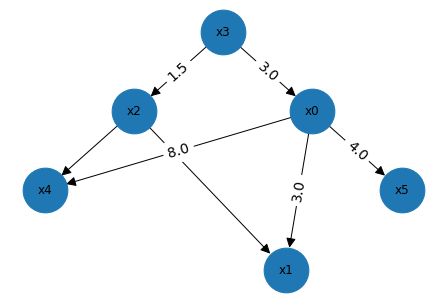

### Test data

,x0,x1,x2,x3,x4,x5
0,2.457959,3.979581,b,0.548814,10.245798,10.198616
1,2.621652,8.431475,a,0.715189,21.602835,10.784233
2,2.331446,7.131753,a,0.602763,19.430153,9.394384
3,1.885170,3.177467,b,0.544883,8.392238,7.893208
4,1.876007,5.681239,a,0.423655,15.824472,7.736226
...,...,...,...,...,...,...
995,1.234716,2.070230,b,0.097676,5.288504,5.043098
996,2.090899,3.371803,b,0.514922,8.798471,8.503125
997,3.138850,9.613938,a,0.938412,25.940801,13.251922
998,1.499485,2.647914,b,0.228647,6.930745,6.481635


In [2]:
display(Markdown("### Causal graph"))

G = np.array([[0.0, 0.0, 0.0, 3.0, 0.0, 0.0],
              [3.0, 0.0, 1.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 1.5, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
              [8.0, 0.0, 1.0, 0.0, 0.0, 0.0],
              [4.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

display(G)

graph = nx.DiGraph()

graph.add_node("x0", pos=(3, 1))
graph.add_node("x1", pos=(2.7, -1))
graph.add_node("x2", pos=(1, 1))
graph.add_node("x3", pos=(2, 2))
graph.add_node("x4", pos=(0, 0))
graph.add_node("x5", pos=(4, 0))

edges = []
edge_labels = {}
for to, from_ in np.argwhere(~np.isclose(G, 0)):
    edges.append((f"x{from_}", f"x{to}"))
    if from_ == 2:
        continue
    edge_labels[(f"x{to}", f"x{from_}")] = G[to, from_]
graph.add_edges_from(edges)
pos = nx.get_node_attributes(graph, "pos")
nx.draw(graph, pos, with_labels=True, arrowsize=20, node_size=2000)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=14)
plt.show() 

display(Markdown("### Test data"))

N = 1000

X = {}

X["x3"] = np.random.uniform(size=N)

X["x2"] = np.empty(N).astype(str)
for i in range(N):
    prob_a = expit(G[2, 3] * X["x3"][i] - 0.5)
    X["x2"][i] = np.random.choice(["a", "b"], p=[prob_a, 1 - prob_a])

X["x0"] = G[0, 3] * X["x3"] + np.random.uniform(size=N)

X["x4"] = np.empty(N)
for i in range(N):
    if X["x2"][i] == "a":
        X["x4"][i] = 8.0 * X["x0"][i] + np.random.uniform()
    elif X["x2"][i] == "b":
        X["x4"][i] = 4.0 * X["x0"][i] + np.random.uniform()

X["x1"] = np.empty(N)
for i in range(N):
    if X["x2"][i] == "a":
        X["x1"][i] = 3.0 * X["x0"][i] + np.random.uniform()
    elif X["x2"][i] == "b":
        X["x1"][i] = 1.5 * X["x0"][i] + np.random.uniform()

X["x5"] = G[5, 0] * X["x0"] + np.random.uniform(size=1000)

X = pd.DataFrame(X)
X["x2"] = X["x2"].astype("category")
X = X[sorted(X.columns)]

display(X)

## Simulation

Running *run()* after running *train()* will simulate data based on the data and causal graphs given at *train()* or variables and models given at *run()*.

*run()* can specify *changing_exog* and *changing_models* as optional arguments. Let's first run without setting any optional arguments.

In [3]:
sim = CausalBasedSimulator()
sim.train(X, G)

sim_df = sim.run()
sim_df

,x0,x1,x2,x3,x4,x5
0,2.457959,3.979581,b,0.548814,10.245798,10.198616
1,2.621652,8.431475,a,0.715189,21.602835,10.784233
2,2.331446,3.605910,b,0.602763,10.091768,9.394384
3,1.885170,3.177467,b,0.544883,8.392238,7.893208
4,1.876007,5.681239,a,0.423655,15.824472,7.736226
...,...,...,...,...,...,...
995,1.234716,2.070230,b,0.097676,5.288504,5.043098
996,2.090899,3.371803,b,0.514922,8.798471,8.503125
997,3.138850,4.862930,b,0.938412,13.354864,13.251922
998,1.499485,2.647914,b,0.228647,6.930745,6.481635


The simulation results are returned as the return value of run(). The same data can be obtained by accessing *sim.simulated_data_*.

In *train()*, the causal graph was analyzed to find the parent-child relationship of each variable, and the data corresponding to the explanatory variables were extracted from the argument data frame *X*. However, *run()* does not extract the values of the explanatory variables from *X*. Instead, it uses the predictions of the parent model as the values of the explanatory variables.

### Distribution of simulated data

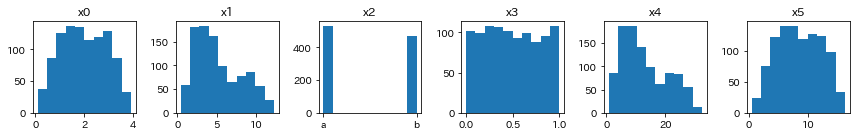

### (Reference) Distribution of test data

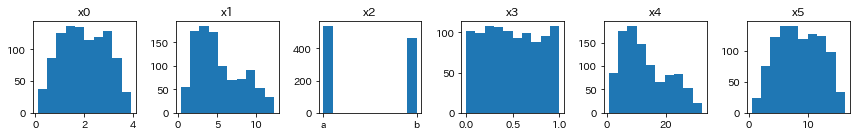

### (Referece) Distribution of residuals

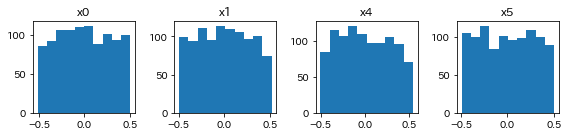

In [4]:
display(Markdown("### Distribution of simulated data"))
fig, axes = plt.subplots(1, sim_df.shape[1], figsize=(2 * sim_df.shape[1], 2))
for ax, (column_name, series) in zip(axes, sim_df.items()):
    ax.hist(sorted(series))
    ax.set_title(column_name)
plt.tight_layout()
plt.show()

display(Markdown("### (Reference) Distribution of test data"))
fig, axes = plt.subplots(1, X.shape[1], figsize=(2 * X.shape[1], 2))
for ax, (column_name, series) in zip(axes, X.items()):
    ax.hist(sorted(series))
    ax.set_title(column_name)
plt.tight_layout()
plt.show()

display(Markdown("### (Referece) Distribution of residuals"))
target_cols = ["x0", "x1", "x4", "x5"]
fig, axes = plt.subplots(1, len(target_cols), figsize=(2 * len(target_cols), 2))
for i, column_name in enumerate(target_cols):
    series = sim.residual_[column_name]
    if not (series.isna().all()):
        axes[i].hist(sorted(series))
    axes[i].set_title(column_name)
plt.tight_layout()
plt.show()

The simulation returns the model's predictions plus the residuals from the training to be the same as the test data, so for this simple data set, the distribution of the simulated and test data is almost equal.

If we subtract the residuals from the simulated results, we get the following. However, x2 is a categorical variable, x3 is most upstream variable, so they do not have residuals.

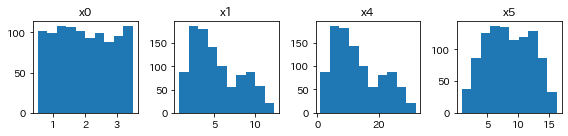

In [5]:
target_cols = ["x0", "x1", "x4", "x5"]
fig, axes = plt.subplots(1, len(target_cols), figsize=(2 * len(target_cols), 2))
for i, column_name in enumerate(target_cols):
    series = sim_df[column_name]
    res = sim.residual_[column_name]
    axes[i].hist(series - res)
    axes[i].set_title(column_name)
plt.tight_layout()
plt.show()

## Simulation by changing exogenous variables

Simulation can also be performed by changing the exogenous variables for each variable. Check the distribution of the exogenous variables of *x0* (residuals at training) and change the exogenous variables. By changing the exogenous variable for *x0*, you will see that *x1*, *x4*, and *x5*, which are descendants of *x0*, are also affected.

### Distribution of exogenous of x0

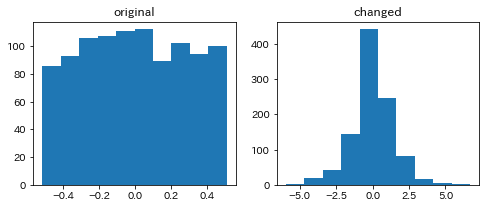

### Distribution of simulated data

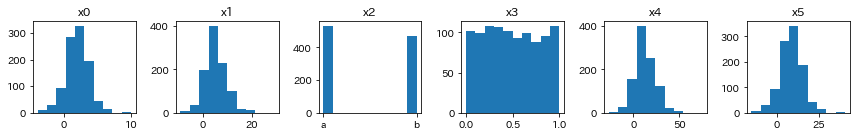

### (Reference) Distribution of simulated data before changing exogenous data

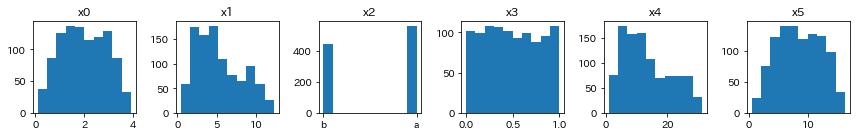

In [6]:
sim = CausalBasedSimulator()
sim.train(X, G)

changing_exog = {
    "x0": np.random.laplace(0, 1, size=X.shape[0])
}

display(Markdown("### Distribution of exogenous of x0"))
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].hist(sim.residual_["x0"])
axes[0].set_title("original")
axes[1].hist(changing_exog["x0"])
axes[1].set_title("changed")
plt.show()

sim_df = sim.run()
sim_df2 = sim.run(changing_exog=changing_exog)

display(Markdown("### Distribution of simulated data"))
fig, axes = plt.subplots(1, sim_df.shape[1], figsize=(2 * sim_df.shape[1], 2))
for ax, (column_name, series) in zip(axes, sim_df2.items()):
    ax.hist(series)
    ax.set_title(column_name)
plt.tight_layout()
plt.show()

display(Markdown("### (Reference) Distribution of simulated data before changing exogenous data"))
fig, axes = plt.subplots(1, sim_df.shape[1], figsize=(2 * sim_df.shape[1], 2))
for ax, (column_name, series) in zip(axes, sim_df.items()):
    ax.hist(series)
    ax.set_title(column_name)
plt.tight_layout()
plt.show()

## Change model and simulate

Simulate by replacing the regression model for *x0* with another trained regression model. Change to a linear regression model that treats the coefficients of *x3* four times as heavily as the model for *x0*.

### Simulation result before change a model

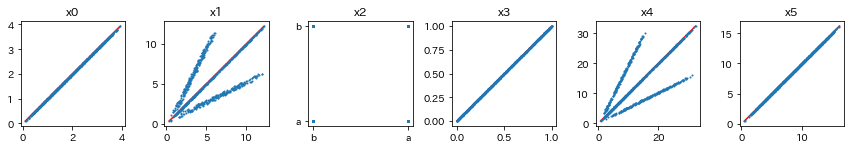

### Simulation result after change a model

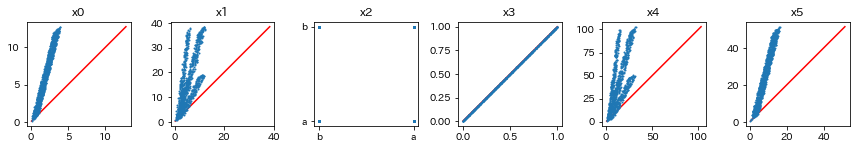

In [7]:
sim = CausalBasedSimulator()
sim.train(X, G)

# before change a model
sim_df = sim.run()

display(Markdown("### Simulation result before change a model"))
fig, axes = plt.subplots(1, X.shape[1], figsize=(2 * X.shape[1], 2))
for ax, (column_name, series) in zip(axes, sim_df.items()):
    ax.scatter(X[column_name], series, s=1)
    if series.dtype.name != "category":
        min_ = min(X[column_name].min(), series.min())
        max_ = max(X[column_name].max(), series.max())
        ax.plot([min_, max_], [min_, max_], color="red", zorder=0)
    ax.set_title(column_name)
    ax.set_aspect(1)
plt.tight_layout()
plt.show()

# after change a model
train_x = X[sim.train_result_["x0"][0]["exp_columns"]].copy()
train_x["x3"] /= 4
train_y = X["x0"]
model = LinearRegression()
model.fit(train_x.values, train_y.values)

changing_models = [
    {
        "name": "x0",
        "condition": None,
        "model": model
    },
]
sim_df2 = sim.run(changing_models=changing_models)

display(Markdown("### Simulation result after change a model"))
fig, axes = plt.subplots(1, X.shape[1], figsize=(2 * X.shape[1], 2))
for ax, (column_name, series) in zip(axes, sim_df2.items()):
    ax.scatter(X[column_name], series, s=1)
    if series.dtype.name != "category":
        min_ = min(X[column_name].min(), series.min())
        max_ = max(X[column_name].max(), series.max())
        ax.plot([min_, max_], [min_, max_], color="red", zorder=0)
    ax.set_title(column_name)
    ax.set_aspect(1)
plt.tight_layout()
plt.show()

You can see that changing the model of *x0* and simulating it produces a different result than before the model change. The simulation values are created by adding the residuals from the output of *train()* to the model's predictions. Since we have changed to a model with large coefficients, the predictions of the model are larger and the simulation values are larger as a result. We can also see that the variables involved in *x0*, *x1*, *x4*, and *x5*, are also affected.

## Simulation by changing exogenous variables and model

So far we have shown examples of changing the exogenous variables and changing the model. Here we will change both and run the simulation.

We will use the same linear regression model as before as the model for *x0*. We also set the residuals as exogenous variables of *x0* when the newly prepared model is applied to the data at *train()* time, so that the simulation results match the original data.

### Distribution of simulated data after change a model and a exogenous (Scatter plot)

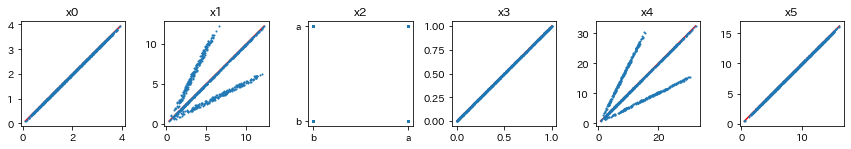

### Distribution of simulated data after change a model and a exogenous (histogram)

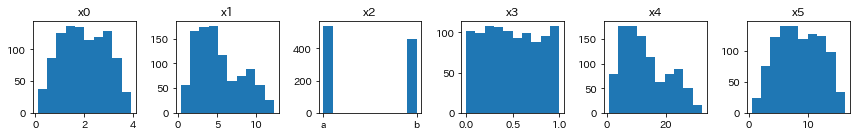

### (Reference) Distribution of test data

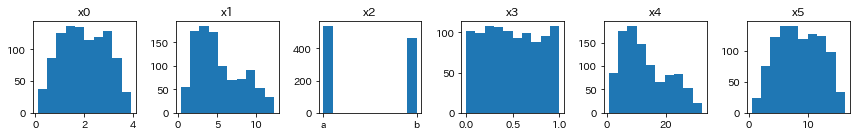

### Coefficients of x0 model

- Original model coef[x0]=2.970, intercept=0.520

- New model coef[x0]=11.881, intercept=0.520

### Distribution of exogenous of x0

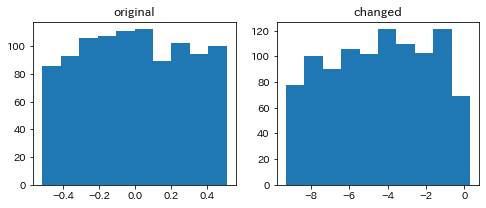

In [8]:
sim = CausalBasedSimulator()
sim.train(X, G)

# before change
sim_df = sim.run()

# change model and exogenous
cols = sim.train_result_["x0"][0]["exp_columns"]
train_x = X[cols].copy()
train_x["x3"] /= 4
train_y = X["x0"]
model = LinearRegression()
model.fit(train_x.values, train_y.values)
resid = train_y - model.predict(X[cols].values)

changing_models = [
    {
        "name": "x0",
        "condition": None,
        "model": model
    },
]
changing_exog = {
    "x0": resid,
}
sim_df2 = sim.run(changing_exog=changing_exog, changing_models=changing_models)

display(Markdown("### Distribution of simulated data after change a model and a exogenous (Scatter plot)"))
fig, axes = plt.subplots(1, X.shape[1], figsize=(2 * X.shape[1], 2))
for ax, (column_name, series) in zip(axes, sim_df2.items()):
    ax.scatter(X[column_name], series, s=1)
    if series.dtype.name != "category":
        min_ = min(X[column_name].min(), series.min())
        max_ = max(X[column_name].max(), series.max())
        ax.plot([min_, max_], [min_, max_], color="red", zorder=0)
    ax.set_title(column_name)
    ax.set_aspect(1)
plt.tight_layout()
plt.show()

display(Markdown("### Distribution of simulated data after change a model and a exogenous (histogram)"))
fig, axes = plt.subplots(1, X.shape[1], figsize=(2 * X.shape[1], 2))
for ax, (column_name, series) in zip(axes, sim_df2.items()):
    ax.hist(sorted(series))
    ax.set_title(column_name)
plt.tight_layout()
plt.show()

display(Markdown("### (Reference) Distribution of test data"))
fig, axes = plt.subplots(1, X.shape[1], figsize=(2 * X.shape[1], 2))
for ax, (column_name, series) in zip(axes, X.items()):
    ax.hist(sorted(series))
    ax.set_title(column_name)
plt.tight_layout()
plt.show()

old_model = sim.train_result_["x0"][0]["model"]
display(Markdown("### Coefficients of x0 model"))
display(Markdown(f"- Original model coef[x0]={old_model.coef_[0]:.3f}, intercept={old_model.intercept_:.3f}"))
display(Markdown(f"- New model coef[x0]={model.coef_[0]:.3f}, intercept={model.intercept_:.3f}"))

display(Markdown("### Distribution of exogenous of x0"))
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].hist(sim.residual_["x0"])
axes[0].set_title("original")
axes[1].hist(changing_exog["x0"])
axes[1].set_title("changed")
plt.show()

The model was changed, but the distribution is similar to the test data because the residuals of that model were given as residuals.

## Manipulating categorical variables
Since there are no residuals in the classification model, changing_exog for categorical variables is ignored. To change the output of a model for a categorical variable, use changing_models as follows.

In [9]:
# inheritance of ClassifierMixin for classification models and RegressorMixin for regression models is required.
class NewModelX2(BaseEstimator, ClassifierMixin):
    
    def __init__(self, classes=None):
        # classes_ is required for the classification model.
        self.classes_ = np.arange(len(classes))

    # For classification models, predict_proba() is required.
    # For regression models, predict() is required.
    def predict_proba(self, X):
        proba = [[0.95, 0.05]] * X.shape[0]
        return np.array(proba)

sim = CausalBasedSimulator()
sim.train(X, G)
sim_df = sim.run()

model = NewModelX2(sim.categorical_info_["x2"])
sim_df2 = sim.run(changing_models=[
    {
        "name": "x2",
        "condition": None,
        "model": model
    },
])

### Before manipulating x2

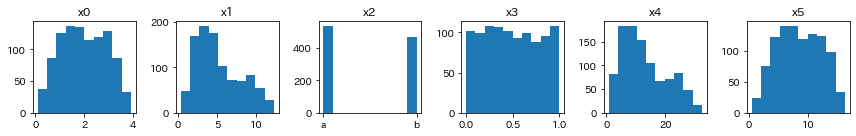

### After manipulating x2

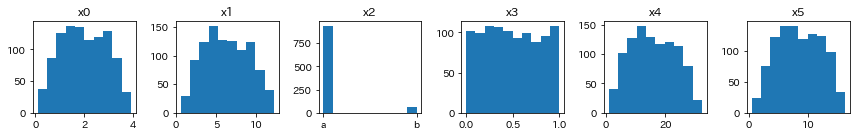

### Difference before and after x2 operation

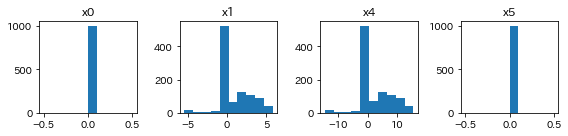

In [10]:
display(Markdown("### Before manipulating x2"))
fig, axes = plt.subplots(1, X.shape[1], figsize=(2 * X.shape[1], 2))
for ax, (column_name, series) in zip(axes, sim_df.items()):
    ax.hist(series)
    ax.set_title(column_name)
plt.tight_layout()
plt.show()

display(Markdown("### After manipulating x2"))
fig, axes = plt.subplots(1, X.shape[1], figsize=(2 * X.shape[1], 2))
for ax, (column_name, series) in zip(axes, sim_df2.items()):
    ax.hist(series)
    ax.set_title(column_name)
plt.tight_layout()
plt.show()

display(Markdown("### Difference before and after x2 operation"))
target_cols = ["x0", "x1", "x4", "x5"]
fig, axes = plt.subplots(1, len(target_cols), figsize=(2 * len(target_cols), 2))
for i, column_name in enumerate(target_cols):
    series = sim_df[column_name]
    series2 = sim_df2[column_name]
    if series.dtype.name != "category":
        series2 = sim_df2[column_name]
        axes[i].hist(series2 - series)
        axes[i].set_title(column_name)
plt.tight_layout()
plt.show()

It can be seen that the distribution of x1 and x4 with x2 as a parent changes before and after the x2 operation, and that there is a difference in values before and after the operation.

## Shuffle residuals to be added when simulating
When run() is executed, simulation is performed by adding the training residuals to the predictions. By default, the residuals to be added to the predictions are the training residuals for the same sample. By using the option shuffle_residual, the residuals are shuffled and added together.

In [11]:
sim = CausalBasedSimulator()
sim.train(X, G)

sim_df = sim.run()
sim_df2 = sim.run(shuffle_residual=True)
sim_df3 = sim.run(shuffle_residual=True, random_state=0)

### Disable shuffle residuals

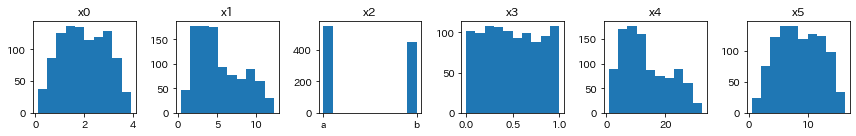

### Enable shuffle residuals

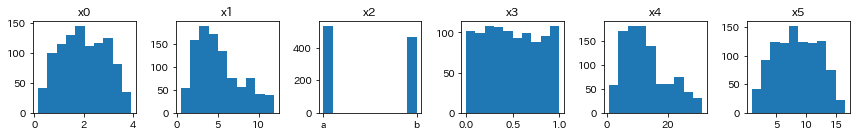

### Difference between disable and enable shuffle reisudals

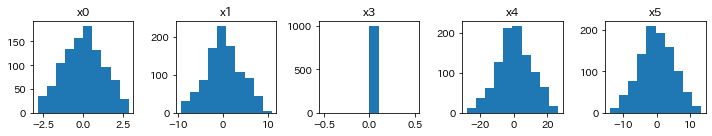

In [12]:
display(Markdown("### Disable shuffle residuals"))
fig, axes = plt.subplots(1, X.shape[1], figsize=(2 * X.shape[1], 2))
for ax, (column_name, series) in zip(axes, sim_df.items()):
    ax.hist(sorted(series))
    ax.set_title(column_name)
plt.tight_layout()
plt.show()

display(Markdown("### Enable shuffle residuals"))
fig, axes = plt.subplots(1, X.shape[1], figsize=(2 * X.shape[1], 2))
for ax, (column_name, series) in zip(axes, sim_df2.items()):
    ax.hist(series)
    ax.set_title(column_name)
plt.tight_layout()
plt.show()

display(Markdown("### Difference between disable and enable shuffle reisudals"))
target_cols = ["x0", "x1", "x3", "x4", "x5"]
fig, axes = plt.subplots(1, len(target_cols), figsize=(2 * len(target_cols), 2))
for i, column_name in enumerate(target_cols):
    series = sim_df[column_name]
    series2 = sim_df2[column_name]
    axes[i].hist(series - series2)
    axes[i].set_title(column_name)
plt.tight_layout()
plt.show()

We can see that there is a difference between the cases with and without shuffling. x2 is a categorical variable, so we did not take the difference. x3 is the most upstream variable, so it has no difference.

# Special machine leaerning models
If the explanatory variables are all categorical variables, the machine learning model has no explanatory variables. In such cases, a special machine learning model prepared in CausalBasedSimulator is used. Use CbsExpectedValueRegressor when the objective variable is a continuous variable and CbsCategoricalClassifier when it is a categorical variable.

CbsExpectedValueRegressor is a machine learning model that returns the expected value of the target variable; *expected_value_* can be accessed after fit(). 

CbsCategoricalClassifier is a machine learning model that returns the generated value of the target variable;*classes_* gives access to the classes of the target variable, and *p_* gives access to the probability of occurrence of the class at the index corresponding to *classes_*.

## Creating test data
x0 is a categorical variable, x1 and x2 are children of x0 and are continuous and categorical variables, respectively. x1 and x2 have only categorical variables as parents, so the machine learning models for x1 and x2 have no explanatory variables.

x1 takes the values 0\~2 when the value of x0 is a and 0~1 when the value of x0 is b. x2 takes the values 75% when the value of x0 is a and 25% when the value of x0 is c to produce d and 25% when the value of x0 is b to produce c to produce d.

### Causal graph (matrix)

array([[0., 0., 0.],
       [2., 0., 0.],
       [2., 0., 0.]])

### Causal graph (picture)

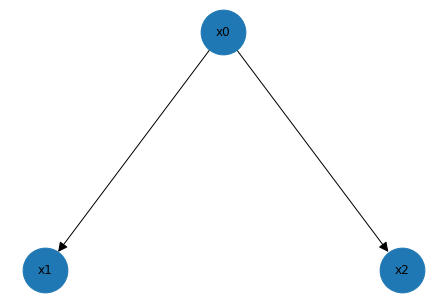

### Test data

,x0,x1,x2
0,b,0.637492,d
1,a,1.625853,c
2,a,0.112440,c
3,a,0.465851,c
4,a,0.635237,c
...,...,...,...
995,b,0.203735,d
996,a,1.830511,c
997,a,1.474971,c
998,a,0.498662,c


In [13]:
display(Markdown("### Causal graph (matrix)"))

G = np.array([[0.0, 0.0, 0.0],
              [2.0, 0.0, 0.0],
              [2.0, 0.0, 0.0]])

display(G)

display(Markdown("### Causal graph (picture)"))

graph = nx.DiGraph()

graph.add_node("x0", pos=(0, 1))
graph.add_node("x1", pos=(-1, 0))
graph.add_node("x2", pos=(1, 0))

edges = []
edge_labels = {}
for to, from_ in np.argwhere(~np.isclose(G, 0)):
    edges.append((f"x{from_}", f"x{to}"))
graph.add_edges_from(edges)
pos = nx.get_node_attributes(graph, "pos")
nx.draw(graph, pos, with_labels=True, arrowsize=20, node_size=2000)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=14)
plt.show() 

display(Markdown("### Test data"))

N = 1000

X = {}

X["x0"] = np.random.choice(["a", "b"], p=[0.75, 0.25], size=N)

X["x1"] = []
for i in range(N):
    if X["x0"][i] == "a":
        X["x1"].append(np.random.uniform() * 2)
    elif X["x0"][i] == "b":
        X["x1"].append(np.random.uniform())
        
X["x2"] = []
for i in range(N):
    if X["x0"][i] == "a":
        X["x2"].append(np.random.choice(["c", "d"], p=[0.75, 0.25]))
    elif X["x0"][i] == "b":
        X["x2"].append(np.random.choice(["c", "d"], p=[0.25, 0.75]))
        
        
X = pd.DataFrame(X)
X["x0"] = X["x0"].astype("category")
X["x2"] = X["x2"].astype("category")
X = X[sorted(X.columns)]

display(X)

## Distribution of test data

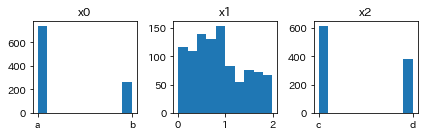

## Distribution of x1 and x2

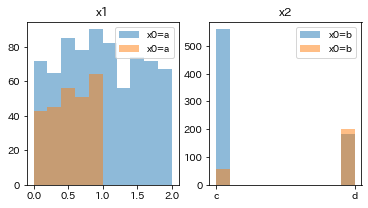

In [14]:
display(Markdown("## Distribution of test data"))
fig, axes = plt.subplots(1, X.shape[1], figsize=(2 * X.shape[1], 2))
for ax, (column_name, series) in zip(axes, X.items()):
    ax.hist(sorted(series))
    ax.set_title(column_name)
plt.tight_layout()
plt.show()

display(Markdown("## Distribution of x1 and x2"))
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

X_a = X[X["x0"] == "a"]
axes[0].hist(X_a["x1"], range=(0, 2), alpha=0.5, label="x0=a")
axes[1].hist(sorted(X_a["x2"]), alpha=0.5, label="x0=b")

X_b = X[X["x0"] == "b"]
axes[0].hist(X_b["x1"], range=(0, 2), alpha=0.5, label="x0=a")
axes[1].hist(sorted(X_b["x2"]), alpha=0.5, label="x0=b")

axes[0].set_title("x1")
axes[0].legend()
axes[1].set_title("x2")
axes[1].legend()

plt.show()

In [15]:
sim = CausalBasedSimulator()
sim.train(X, G)

sim_df = sim.run()

## Distribution of simulated data

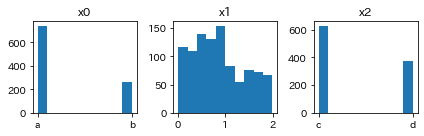

In [16]:
display(Markdown("## Distribution of simulated data"))
fig, axes = plt.subplots(1, sim_df.shape[1], figsize=(2 * sim_df.shape[1], 2))
for ax, (column_name, series) in zip(axes, sim_df.items()):
    ax.hist(sorted(series))
    ax.set_title(column_name)
plt.tight_layout()
plt.show()